In [5]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

# Reversible Jump

## Gaussian Mixture Model

We consider the Gaussian Mixture Model:

$$\sum_{k = 1}^{K}\pi_k\phi_k(y_i)$$

Where $K$ is unknown.

In [12]:
function get_prob(μ; τ, Y)
    pdf.(Normal(μ, 1/τ), Y)
end

function get_posterior_ll(Y, π, μ, τ, prior_μ, prior_π)
    K = length(μ)
    ll = sum(log.(pdf.(prior_μ, μ))) + log(pdf(prior_π, π))
    ll += sum(log.(π' * transpose(reduce(hcat, get_prob.(μ, τ=τ, Y=Y))))) 
    ll
end

function draw_Z(Y; μ, π, τ)
    K = length(π)
    p = zeros(K)
    for i in range(1, K)
        p[i] = pdf(Normal(μ[i], 1/τ), Y) * π[i]
    end
    p = p ./ sum(p)
    sample([1:1:K;], Weights(p))
end

function gibbs_update(Y; μ, μ0, π, τ, τ0)
    K = length(π)
    # draw Z1, ..., Zn
    Z = draw_Z.(Y, μ=μ, π=π, τ=τ)
    # draw μ1, ..., μK
    cts = [sum(Z .== k) for k in range(1, K)]
    new_μ = zeros(K)
    μ = zeros(K)
    for k in range(1, K)
        τ_k = (cts[k] * τ + τ0)
        new_μ[k] = sum(Y[Z .== k]) * τ + τ0*μ0
        new_μ[k] = new_μ[k] / τ_k
        μ[k] = rand(Normal(new_μ[k], 1 / τ_k))
    end
    # draw π1, ..., πK
    π = rand(Dirichlet(fill(1, K) .+ cts))
    μ, π
end

function generate_jump_matrix(max_K)
    jump_matrix = zeros(max_K, max_K)
    for i in range(2, max_K - 1)
        jump_matrix[i, i - 1] = 0.1
        jump_matrix[i, i + 1] = 0.2
        jump_matrix[i, i] = 0.7
    end
    jump_matrix[1, 1] = 0.8
    jump_matrix[1, 2] = 0.2
    jump_matrix[max_K, max_K] = 0.8
    jump_matrix[max_K, max_K - 1] = 0.2
    jump_matrix
end

function reversible_jump(Y; max_K, μ0, π0, τ0, τ, prior_μ, N_iter=20000)
    jump_matrix = generate_jump_matrix(max_K)
    K = Array{Int32, 1}(undef, N_iter)
    μ_ls = [[μ0]]
    π_ls = [[π0]]
    K[1] = 1
    for t in range(2, N_iter)
        k = K[t - 1]
        # decide to jump or to stay in the same model
        next_k = sample([1:1:max_K;], Weights(jump_matrix[k, :]))
        if next_k == k
            # update current model
            K[t] = k
            μ, π = gibbs_update(Y; μ=μ_ls[t - 1], π=π_ls[t - 1], 
                τ=τ, τ0=τ0, μ0=μ0)
            append!(μ_ls, [μ])
            append!(π_ls, [π])
        else
            g1 = Beta(1, k)
            g2 = Normal(0, 10)
            if next_k == k + 1
                # attempt to jump up
                u1 = rand(g1)
                u2 = rand(g2)
                while u2 < μ_ls[t - 1][k]
                    u2 = rand(g2)
                end
                π = vcat(π_ls[t - 1] .* (1 - u1), u1)
                μ = vcat(μ_ls[t - 1], u2)
                log_alpha = get_posterior_ll(Y, π, μ, τ, prior_μ, Dirichlet(fill(1, k + 1))) - 
                    get_posterior_ll(Y, π_ls[t - 1], μ_ls[t - 1], τ, prior_μ, Dirichlet(fill(1, k)))+ 
                    jump_matrix[k + 1, k] - jump_matrix[k, k + 1] - 
                    log(pdf(g1, u1)) - log(pdf(g2, u2)) + 
                    k * log(1 - u1)
                #println(π, μ, log_alpha)
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(μ_ls, [μ_ls[t - 1]])
                    append!(π_ls, [π_ls[t - 1]])
                else
                    K[t] = k + 1
                    append!(μ_ls, [μ])
                    append!(π_ls, [π])
                end
            else
                # attempt to jump down
                u2 = μ_ls[t - 1][k]
                u1 = π_ls[t - 1][k]
                π = π_ls[t - 1][1:k-1] ./ (1 - u1)
                μ = μ_ls[t - 1][1:k-1]
                log_alpha = - get_posterior_ll(Y, π, μ, τ, prior_μ, Dirichlet(fill(1, k - 1))) +
                    get_posterior_ll(Y, π_ls[t - 1], μ_ls[t - 1], τ, prior_μ, Dirichlet(fill(1, k))) -
                    jump_matrix[k - 1, k] + jump_matrix[k, k - 1] +
                    log(pdf(g1, u1)) - log(pdf(g2, u2)) -
                    k * log(1 - u1)
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(μ_ls, [μ_ls[t - 1]])
                    append!(π_ls, [π_ls[t - 1]])
                else
                    K[t] = k - 1
                    append!(μ_ls, [μ])
                    append!(π_ls, [π])
                end
            end       
        end
    end
    μ_ls, π_ls, K
end

function plot_estimates(param, k)
    y = transpose(reduce(hcat, param[K .== k]))
    p = plot(y, layout = (1, 2), subplot = 1, size = (800, 400))
    plot!(p, cumsum(y, dims = 1) ./ [1:1:size(y)[1];], subplot = 2)
    display(p)
end;

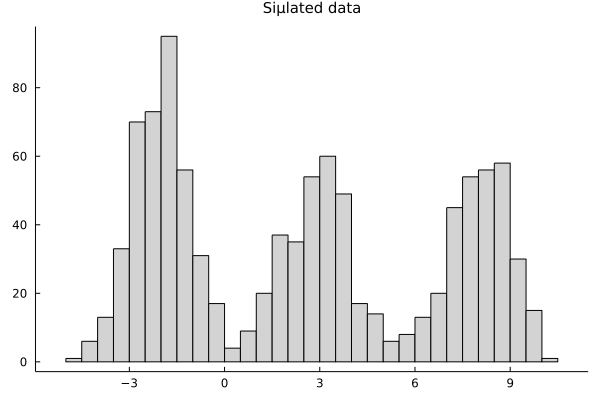

In [13]:
# parameters
μ = [-2, 3, 8]
τ = 1
π = [0.4, 0.3, 0.3]
N = 1000
K = length(μ)

# data siμlation
Y = zeros(0)
for i in range(1, K)
    append!(Y, rand(Normal(μ[i], 1/τ), Int(N * π[i])))
end

histogram(Y, bins=40, title="Siμlated data")

In [17]:
μ_ls, π_ls, K = reversible_jump(
    Y, 
    max_K=4,
    μ0=0.0, 
    π0=1.0, 
    τ0=1.0, 
    τ=1.0, 
    prior_μ=Normal(0,10)
);

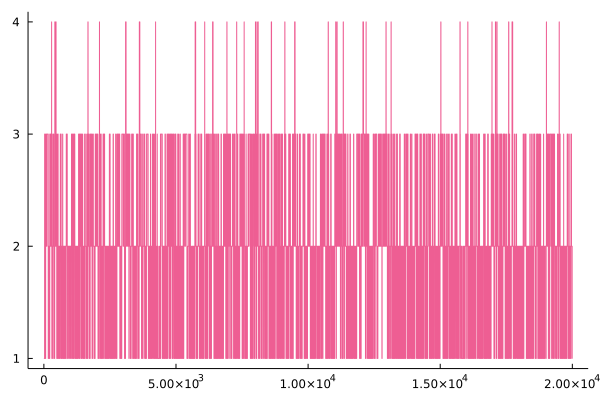

In [18]:
plot(K, color=7)

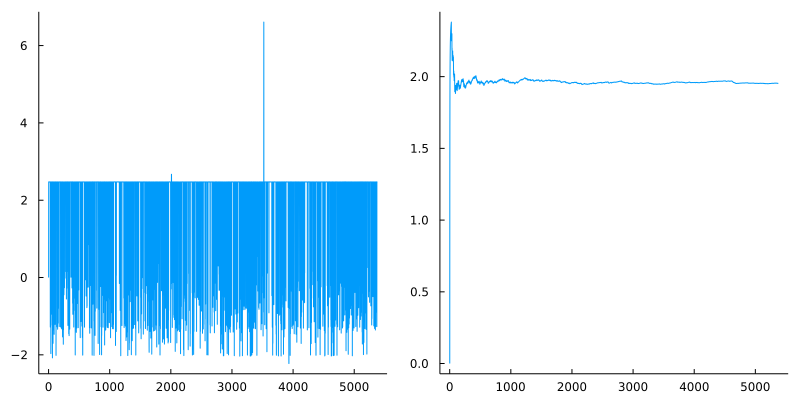

In [19]:
plot_estimates(μ_ls, 1)

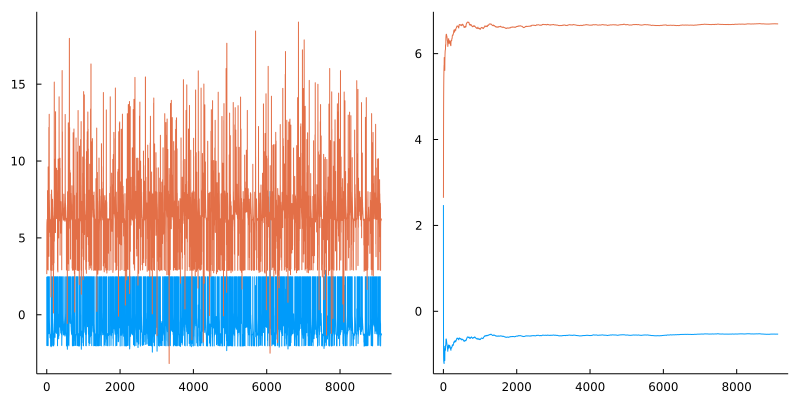

In [20]:
plot_estimates(μ_ls, 2)

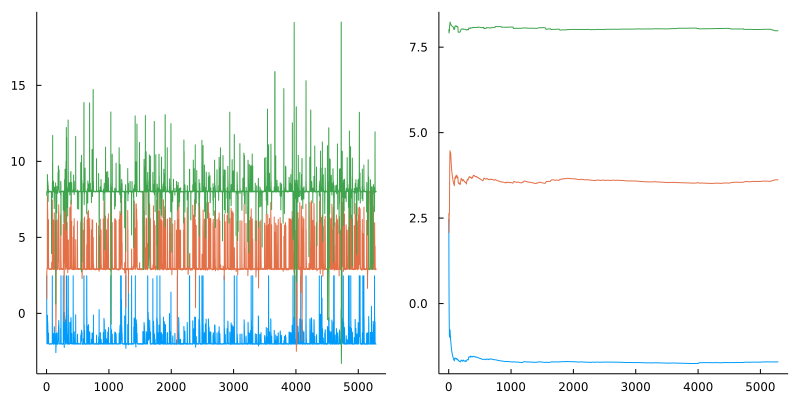

In [21]:
plot_estimates(μ_ls, 3)

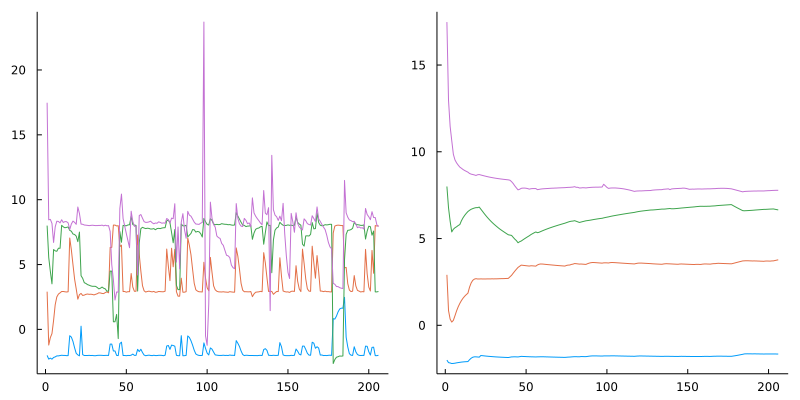

In [22]:
plot_estimates(μ_ls, 4)

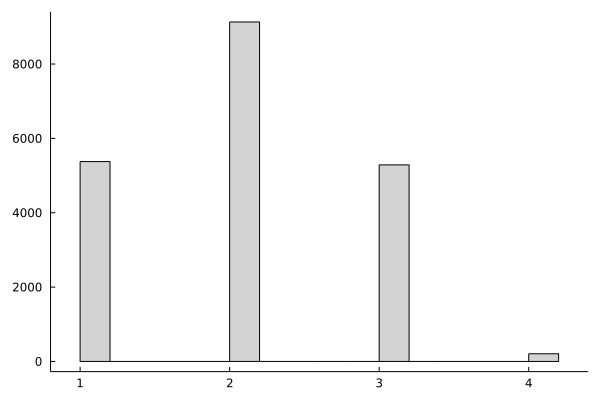

In [23]:
histogram(K)